# Introducción

En esta práctica exploraremos dos técnicas avanzadas de aprendizaje profundo en el ámbito de la generación de imágenes. El objetivo es comprender y aplicar dos tipos de redes neuronales generativas: los Autoencoders Variacionales (VAE) y las Redes Generativas Antagónicas (GAN). A continuación, se describen los ejercicios propuestos para esta práctica:




1.   **Autoencoder Variacional con Fashion MNIST**

El primer ejercicio consiste en entrenar un Autoencoder Variacional (VAE) utilizando el conjunto de datos fashion_mnist de Keras, el cual incluye imágenes de prendas de la tienda online Zalando. El propósito de un VAE es aprender una representación latente compacta de los datos. Tras entrenar el modelo, se utilizará la red de decodificación para transformar vectores del espacio latente en imágenes. Este ejercicio nos permitirá visualizar cómo diferentes puntos en el espacio latente corresponden a diversas imágenes generadas, ofreciendo una visión intuitiva sobre la estructura interna aprendida por el VAE.

2.   **GAN para generación de imágenes de zapatos**

En el segundo ejercicio, abordaremos la generación de imágenes utilizando una Red Generativa Antagónica (GAN). Utilizaremos una base de datos proporcionada por la Universidad de Texas, que contiene imágenes de zapatos. El objetivo será entrenar una GAN para que aprenda a generar nuevas imágenes de zapatos que no se encuentren en el conjunto de datos original. Las GANs son especialmente poderosas para este tipo de tareas, ya que pueden aprender a imitar cualquier distribución de datos dada una suficiente capacidad y tiempo de entrenamiento.


# 1.   **Autoencoder Variacional**

Se carga el conjunto de imágenes utilizado para entrenar el modelo VAE.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, _), (x_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


In [ ]:
print("Se dispone de " + str(x_train.shape[0]) + " imágenes de entrenamiento.")
print("Se dispone de " + str(x_test.shape[0]) + " imágenes de test.")
print("Cada imagen tiene una dimensión de " + str(x_train.shape[1]) + " x " + str(x_train.shape[2]))

Se dispone de 60000 imágenes de entrenamiento.
Se dispone de 10000 imágenes de test.
Cada imagen tiene una dimensión de 28 x 28


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2 # Se utiliza un plano 2D para poder graficar la gradualidad de
               # los cambios en las imágenes en 2 ejes

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

El siguiente código es para **generar un punto espacial latente ``z``** usando ``z_mean`` y ``z_log_var``, los parámetros de la distribución estadística que se supone que produjeron ``input_img``:

**Capa de muestreo-espacio-latente (Latent-space-sampling)**

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

El siguiente código es la **implementación del decodificador**. Redimensionamos el vector ``z`` a las dimensiones de una imagen y luego usamos algunas capas de convolución para obtener una salida de imagen final que tiene las mismas dimensiones que la ``input_img`` original.

**Red de decodificadores VAE, asignando puntos de espacio latente a imágenes**

In [ ]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

Creamos el **propio modelo VAE**. Un autoencoder es un modelo de **aprendizaje autosupervisado**, porque **utiliza sus entradas como objetivos**. Cada vez que se sale del aprendizaje supervisado clásico, es **común crear una subclase de la clase ``Model`` e implementar un ``train_ step()`` personalizado para especificar la nueva lógica de entrenamiento**.

**Modelo VAE con `train_step()` personalizado**

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Ahora **instanciamos y entrenar el modelo en dígitos MNIST**. Debido a que la **pérdida se soluciona en la capa personalizada**, **no especificamos una pérdida externa** en el momento de la compilación (``loss=None``), lo que a su vez significa que **no pasaremos los datos target durante el entrenamiento** (como podemos ver, solo pasamos ``x_train`` al modelo en ``fit()``).

**Entrenando la VAE**

In [ ]:
import numpy as np

# Entrenamos en todos los dígitos MNIST, por lo que
# concatenamos las muestras de entrenamiento y prueba.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30


547/547 [==============================] - 39s 60ms/step - total_loss: 335.0633 - reconstruction_loss: 328.2886 - kl_loss: 6.7746
Epoch 2/30
547/547 [==============================] - 33s 61ms/step - total_loss: 285.3401 - reconstruction_loss: 279.6650 - kl_loss: 5.6754
Epoch 3/30
547/547 [==============================] - 31s 57ms/step - total_loss: 275.3545 - reconstruction_loss: 270.2717 - kl_loss: 5.0827
Epoch 4/30
547/547 [==============================] - 31s 57ms/step - total_loss: 272.1874 - reconstruction_loss: 267.3006 - kl_loss: 4.8869
Epoch 5/30
547/547 [==============================] - 31s 57ms/step - total_loss: 270.2529 - reconstruction_loss: 265.4644 - kl_loss: 4.7884
Epoch 6/30
547/547 [==============================] - 31s 57ms/step - total_loss: 268.9311 - reconstruction_loss: 264.1949 - kl_loss: 4.7363
Epoch 7/30
547/547 [==============================] - 31s 56ms/step - total_loss: 267.6850 - reconstruction_loss: 263.0136 - kl_loss: 4.6715
Epoch 8/30
547/547 [====

Una vez que se entrena el modelo, podemos **usar la red ``decoder``** para **convertir vectores espaciales latentes arbitrarios en imágenes**.

**Muestreo de una cuadrícula de imágenes del espacio latente 2D**

1/1 [==============================] - 0s 18ms/step


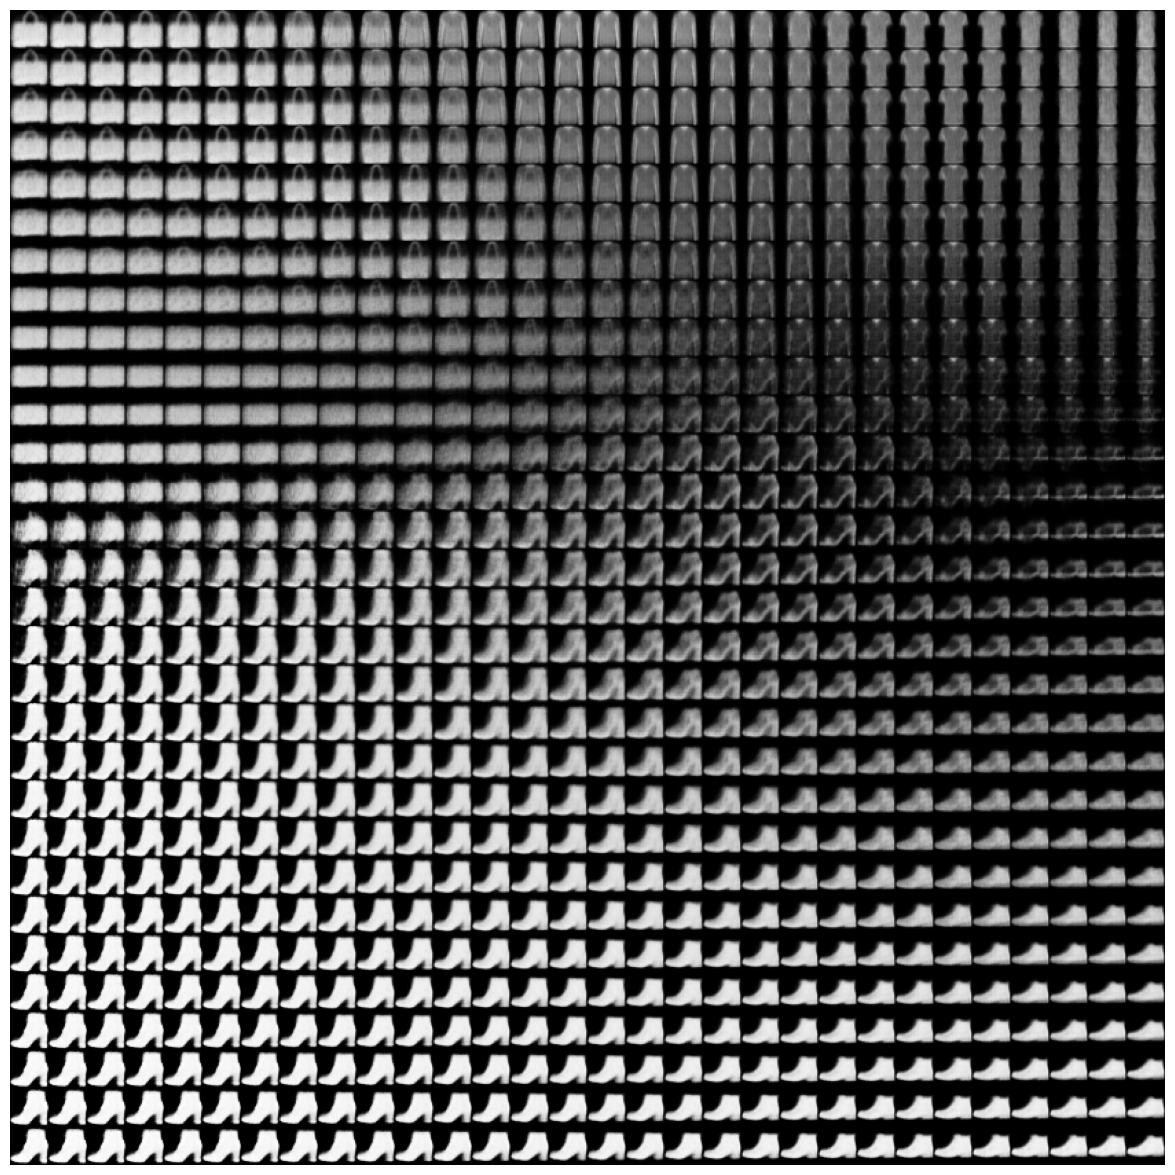

In [ ]:
import matplotlib.pyplot as plt

n = 30
image_size = 28
figure = np.zeros((image_size * n, image_size * n))

# Muestreo de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        image = x_decoded[0].reshape(image_size, image_size)
        figure[
            i * image_size : (i + 1) * image_size,
            j * image_size : (j + 1) * image_size,
        ] = image

plt.figure(figsize=(15, 15))
start_range = image_size // 2
end_range = n * image_size + start_range
pixel_range = np.arange(start_range, end_range, image_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

Se observa la gradualidad característica de los modelos VAE en estos 2 ejes, entre las distintas prendas de ropa. Se crean prendas de ropa inexistentes en la realidad que combinan características de otras existentes.

En este caso, debido al contexto, no tienen mucho valor las imágenes decodificadas a partir de valores intermedios entre puntos pertenecientes a imágenes de ropa reales.

Para otras aplicaciones de este tipo de modelos en los que son relevantes estos puntos intermedios, se podría aumentar la dimensión del espacio latente para captar mejor las características del conjunto de entrenamiento y obtener imágenes con mayor claridad en las formas de los objetos. El único problema de esto, es que las características codificadas en estos puntos de mayor dimensionalidad, solo podrían estudiarse graficando por pares las dimensiones y no todas de manera simultánea.

Por otro lado, se podrían realizar cambios estructurales y de valores de hiperparámetros en el codificador y en el decodificador, o incluso probar otros valores de parámetros que afecten exclusivamente a la fase de entrenamiento. Debido a la nula utilidad práctica de estas modificaciones por los motivos mencionados previamente, no se realiza ningun cambio. Además, puede ser complicado valorar objetivamente las imágenes creadas a partir de puntos intermedios, ya que no aportan ningún valor real en este caso.

La única faceta destacable obtenida, es con las imágenes de puntos intermedios entre zapatos y botas con tacón. Esto, se debe a que son prendas relativamente similares en cuanto a forma y utilidad en comparación con las demás, haciendo coherentes las imágenes creadas con características de ambas para conservar la funcionalidad práctica y obtener nuevas características de diseño.

# 2.   **Red Generativa Antagónica**



Se carga el conjunto de imágenes utilizado para entrenar el modelo GAN.

In [ ]:
# Creamos el directorio de trabajo
!mkdir zapatos_gan

# Descargamos los datos directamente desde la URL
!wget https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip -O zapatos_gan/data.zip

# Descomprimimos los datos
!unzip -qq zapatos_gan/data.zip -d zapatos_gan

--2024-05-06 13:38:45--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘zapatos_gan/data.zip’

zapatos_gan/data.zi 100%[===================>] 137.55M   102MB/s    in 1.3s    

2024-05-06 13:38:47 (102 MB/s) - ‘zapatos_gan/data.zip’ saved [144233542/144233542]



Usamos **``image_dataset_from_directory`` para convertirlo en un dataset.** Dado que **solo necesitamos las imágenes, no hay etiquetas**, especificaremos **``label_mode=None``**.

**Creamos un dataset a partir de un directorio de imágenes**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "zapatos_gan",
    # Solo se devolverán las imágenes, sin etiquetas.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # Cambiaremos el tamaño de las imágenes a 64 × 64
    # usando una combinación inteligente de recorte y
    # cambio de tamaño para preservar la relación de
    # aspecto.
    smart_resize=True)

Found 50066 files belonging to 1 classes.


Finalmente, cambiamos la **escala de las imágenes al rango ``[0-1]``**

**Rescalamos las imágenes**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**Mostramos la primera imagen**

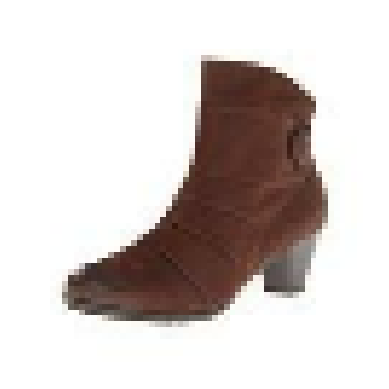

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Discriminator

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

## Generator

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

## Clase GAN

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

### Callback

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

## Entrenamiento

In [ ]:
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/30
1565/1565 [==============================] - 399s 246ms/step - d_loss: 0.1947 - g_loss: 13.2874
Epoch 2/30
1565/1565 [==============================] - 386s 246ms/step - d_loss: 0.5942 - g_loss: 1.2566
Epoch 3/30
1565/1565 [==============================] - 385s 246ms/step - d_loss: 0.6229 - g_loss: 1.0913
Epoch 4/30
1565/1565 [==============================] - 385s 246ms/step - d_loss: 0.6286 - g_loss: 1.0885
Epoch 5/30
1565/1565 [==============================] - 391s 250ms/step - d_loss: 0.6488 - g_loss: 1.0187
Epoch 6/30
1565/1565 [==============================] - 391s 250ms/step - d_loss: 0.6445 - g_loss: 1.0064
Epoch 7/30
1565/1565 [==============================] - 385s 246ms/step - d_loss: 0.6586 - g_loss: 0.9923
Epoch 8/30
1565/1565 [==============================] - 391s 250ms/step - d_loss: 0.6479 - g_loss: 0.9493
Epoch 9/30
1565/1565 [==============================] - 391s 250ms/step - d_loss: 0.6572 - g_loss: 0.9239
Epoch 10/30
1565/1565 [======================

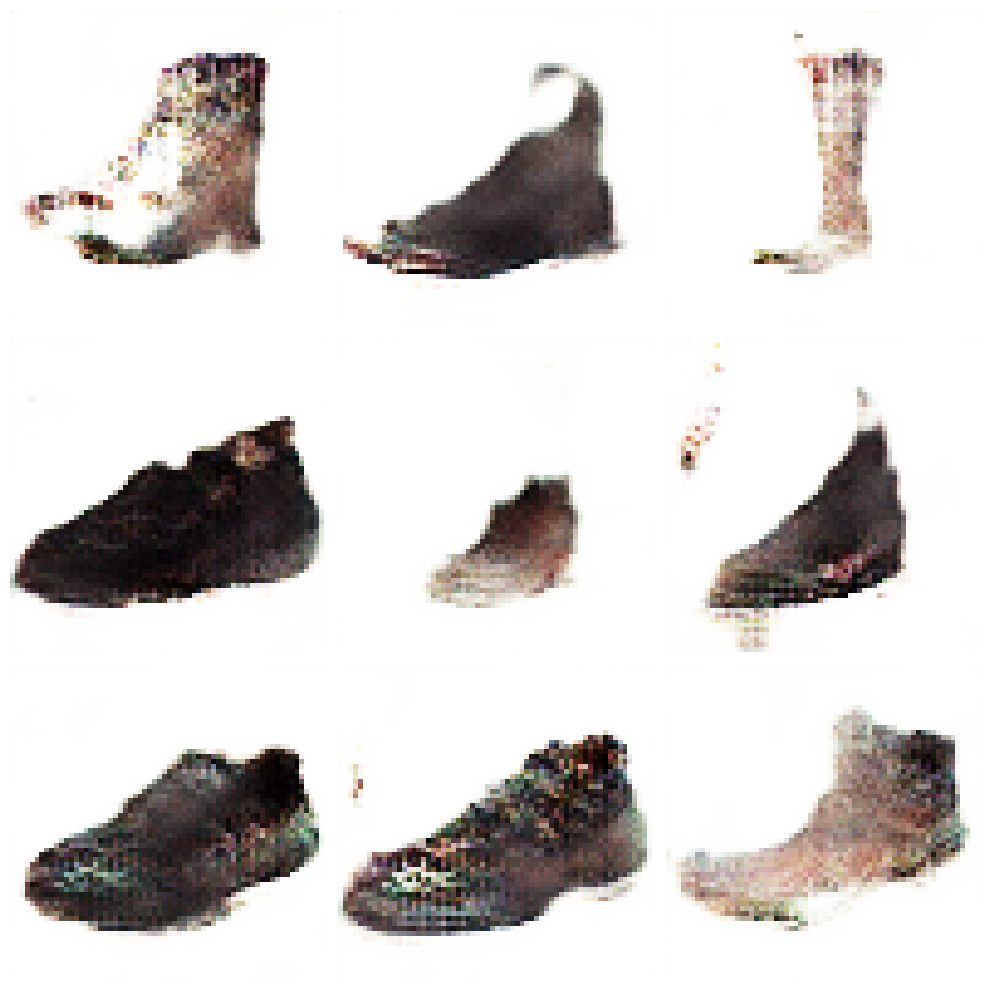

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Nombres de las imágenes almacenadas
image_files = [
    'generated_img_029_0.png', 'generated_img_029_1.png', 'generated_img_029_2.png',
    'generated_img_029_3.png', 'generated_img_029_4.png', 'generated_img_029_5.png',
    'generated_img_029_6.png', 'generated_img_029_7.png', 'generated_img_029_8.png'
]

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 10))

# Mostrar las imágenes en una cuadrícula 3x3
for i, image_file in enumerate(image_files):
    img = mpimg.imread(image_file)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')  # Desactiva los ejes

plt.tight_layout()
plt.show()


Se observa que en algunas imagenes hay zapatos mas nitidos que otros pero que en general no son imagenes igual de limpias que las que tiene el dataset. Esto se puede deber a que la calidad de las imagenes inicialmente no era lo suficientemente buena como para que la red GAN obtuviese el detalle y la nitidez de las imagenes. Finalmente aumentar el numero de epochs o probar redes mas complejas como la StyleGAN (para la cual harian falta imagenes de 1024x1024 pixeles de minimo) serian buenas formas de mejorar la calidad de las imagenes pero en general se puede concluir que la red GAN devuelve imagenes de zapatos lo suficientemente buenas como para entender su funcionamiento.